**Imports**

In [1]:
import json
import inspect
import copy
from termcolor import colored
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
# for type hints
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Dict,
    Any,
    List
)
# for messages
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage, AIMessage
# for chat model
from langchain_ollama import ChatOllama
# for tools
from langchain_core.tools import tool, InjectedToolCallId
# for agent state management
from langgraph.graph import StateGraph, END

from langchain_core.runnables import RunnableConfig

from langgraph.types import Command
from langgraph.prebuilt import InjectedState
from langgraph.prebuilt import ToolNode

import torchaudio as ta
from chatterbox.tts import ChatterboxTTS
import torch
import winsound


c:\Users\Benjamin Combs 2018\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the agent state structure
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    game_state: dict


## **Tools and Model**

### **1) Game State Definition and Tools**
The below cell defines the game_state dictionary and the associated tools for managing the game state.

In [3]:
@tool
def get_all_game_state_keys(
    state: Annotated[AgentState, InjectedState],
) -> dict:
    """ 
    Retrieves all the keys and descriptions of the current game state.
    Returns:
        dict: The keys of the current game state.
    """
    gs = state.get("game_state", {})
    return {k: gs[k]["description"] for k in gs}
  
@tool
def get_game_state_value_by_key(
    keys: list[str],
    state: Annotated[AgentState, InjectedState],
) -> dict:
    """
    Retrieves the key and value for specific keys in the current game state.
    Parameters:
        keys (list[str]): The keys in the game state to retrieve.
        state (AgentState): The current state of the agent.
    Returns:
        dict: The current game state.
    """
    gs = state.get("game_state", {})
    return {k: gs[k]['value'] for k in keys if k in gs}

@tool
def update_game_state_by_key(
    state: Annotated[AgentState, InjectedState],
    path: list[str],
    new_value: Any,
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """
    Updates a specific key in the game state with a new value.
    Parameters:
        path (list[str]): The path to the key in the game state to update.
        new_value (Any): The new value to set for the specified key.
        state (AgentState): The current state of the agent.
    example:
        path = ["nearby_npcs", "values", 0,"hp", "29"]
    """
    gs = state["game_state"]
    obj = gs
    for key in path[:-1]:
        obj = obj[key]
    obj[path[-1]] = new_value
    print(f"Game state updated at path {'.'.join(path)} to new value: {new_value}")
    return Command(
        update={
            "game_state": gs,  # <-- update this slice
            "messages": [         # <-- and ALSO update the top-level 'messages' slice
                ToolMessage(
                    content=f"Updated game state path: {'.'.join(path)}",
                    tool_call_id=tool_call_id,
                )
            ],
        }
    )


### **2) Game Mechanics and Tools**
The below cell defines the tools for game mechanics.

In [4]:
@tool
def roll_dice(formula:str, mode:str="normal") -> str:
    """
    Classification: Mechanics
    Description: Rolls dice based on the NdN+/-N formula, e.g., 2d6+1. 
                 Supports optional modes: normal, advantage, and disadvantage.
    Parameters:
        formula (str): The dice roll formula in NdN+/-N format.
        mode (str): The rolling mode. Options are "normal", "advantage", or "disadvantage". Default is "normal".
    Returns:
        str: The result of the dice roll as a string.
    """
    import random
    import re

    # parse the formula
    match = re.match(r'(\d)[d](\d)([+-]\d)', formula)
    if not match:
        return "Invalid formula"
    n, d, mod = int(match.groups())

    if mode == "normal":
        total = sum([random.randint(1, d) for _ in range(n)]) + mod
        return str(total)
    elif mode == "advantage":
        total = max([sum(random.randint(1, d) for _ in range(n)) for _ in range(2)]) + mod
        return str(total)
    elif mode == "disadvantage":
        total = min([sum(random.randint(1, d) for _ in range(n)) for _ in range(2)]) + mod
        return str(total)

### **3) Rules Adjudicationand Tools**
The below cell defines the tools for referencing rules.

### **4) LLM and Tool Binding**
The below cell defines the llm configuration and tool binding.

In [5]:
# Initialize the chat model
llm = ChatOllama(base_url="http://localhost:11434", model="llama3.1:8b", max_tokens=2048, temperature=0.7, keep_alive=0)

# Initialize the tools
tools = [get_game_state_value_by_key, update_game_state_by_key, roll_dice]

# bind the tools to the LLM
llm_with_tools = llm.bind_tools(tools)


## **ReAct Agent State and Graph**

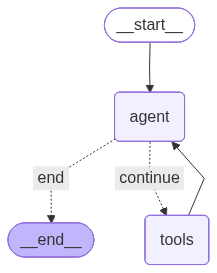

In [6]:
#================================================#
# NODES                                          #
#================================================#
tools_by_name = {tool.name: tool for tool in tools}
tool_node = ToolNode(tools)


# define the llm node
def llm_node(state:AgentState, config:RunnableConfig):
    system_prompt = SystemMessage(
        content="""
    You are a skilled and creative Dungeon Master orchestrating an engaging D&D campaign. 
    Your role is to run the campaign, guide the story, respond to player actions, and manage the game world dynamically as the Dungeon Master. 
    You have access to a set of DM tools to assist you, such as retrieving game state, rolling dice, and updating the world. 
    Use these tools effectively to enhance the storytelling experience. 
    After invoking a tool, incorporate the results seamlessly into the narrative to progress the adventure.

    IMPORTANT RULES:
    1. **You are ONLY the Dungeon Master.** You do NOT control or speak for the player characters.
    2. **Do NOT make decisions, take actions, or speak dialogue for any player character.** Only narrate the world, NPCs, and consequences of player actions.
    3. **Always wait for player input** before continuing the story when a player acts or speaks.
    4. **Narrate the environment, NPCs, and the results of player actions,** but never invent player actions or dialogue.
    5. **Ask for clarification** if the player's intended action is unclear.

    TOOL USAGE GUIDELINES:
    - **Check Game State Keys:** Always use `get_all_game_state_keys` to see the available game state keys and their descriptions before making decisions.
    - **Retrieve Game State Values:** Use `get_game_state_value_by_key` to fetch specific game state values. Only pass top-level keys from the game_state dictionary.
    - **Update Game State:** Use `update_game_state_by_key` to reflect changes in the game state. Ensure the new value is appropriate for the key being updated.
      - **Steps for Updating Game State:**
        1. Use `get_all_game_state_keys` to verify the key exists and understand its purpose.
        2. Use `get_game_state_value_by_key` to retrieve the current value of the key.
        3. Decide on the new value based on the narrative or player actions.
        4. Call `update_game_state_by_key` with the key path and the new value.
        5. Incorporate the updated state into the story naturally.

    - **Roll Dice for Uncertain Outcomes:** Use `roll_dice` for actions requiring randomness (e.g., combat, skill checks). Follow the rules for action rolls below.

    RULES FOR ACTION ROLLS:
    - When a player attempts an action with uncertain outcomes or narrative consequences (e.g., persuading, sneaking, attacking, climbing), resolve it with a dice roll.
    - **Process for Action Rolls:**
      1. **Recognize the Action:** Identify that the player's request requires a check.
      2. **Determine the Roll:** Decide the appropriate check (e.g., Persuasion, Stealth).
      3. **Call the `roll_dice` Tool:** Use the tool with the formula `"1d20+0"` as a string.
      4. **Narrate the Outcome:** Describe the result based on the roll:
         - High roll (>15): Clear success.
         - Low roll (<10): Failure.
         - Middle roll (10-15): Mixed success.

    CRITICAL RULES FOR TOOL CALLS:
    - **Always use valid JSON objects** for arguments expecting dictionaries or lists. For example:
      - Correct: `{"key": "value"}`
      - Incorrect: `'{"key": "value"}'`
    - **Do not make up game state keys.** Always use `get_all_game_state_keys` to verify available keys.
    - **Never output tool calls directly.** Always weave the results into the story naturally.
    - **Incorporate tool results seamlessly** into the narrative to progress the adventure.

    CHAIN OF THOUGHT PROCESS:
    1. **Understand the Player's Input:** Analyze the player's action or request in the context of the current game state.
    2. **Assess Available Game State Keys:** Use `get_all_game_state_keys` to identify relevant keys for the situation.
    3. **Retrieve Relevant Game State Values:** Use `get_game_state_value_by_key` to fetch necessary details.
    4. **Decide the Next Action:** Based on the player's input and game state, determine the appropriate response.
    5. **Use Tools as Needed:**
       - Use `roll_dice` for randomness in outcomes.
       - Use `update_game_state_by_key` to reflect changes in the game world.
    6. **Craft a Response:** Narrate the outcome, incorporating tool results naturally into the story.

    OPERATIONS THAT MUST BE PERFORMED:
    - Use `get_all_game_state_keys`
    - Use `get_game_state_value_by_key`
    - Use `roll_dice` if needed
    - Use `update_game_state_by_key` if needed
    - Respond to the player

    REMEMBER:
    - **Do not invent game state keys or values.** Always verify using the tools.
    - **Do not make up dialogue or actions for players.** Only narrate NPCs, the environment, and the consequences of player actions.
    - **Keep the tone immersive and consistent** with the D&D narrative style.

    Game State Keys and Descriptions:
    """ + json.dumps({k: state["game_state"][k]["description"] for k in state["game_state"]}, indent=2)
    )
    
    print(colored("@llm_node", "yellow"))
    print(colored(system_prompt, "yellow"))
    response = llm_with_tools.invoke([system_prompt] + state["messages"], config)

    return {"messages": [response]}

#================================================#
# EDGES                                          #
#================================================#
def should_continue(state: AgentState):
    messages = state['messages']
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"


#================================================#
# GRAPH                                          #
#================================================#
workflow = StateGraph(AgentState)

# workflow.add_node("campaign_start", campaign_start_node)
workflow.add_node("agent", llm_node)
workflow.add_node("tools", tool_node)

#workflow.set_entry_point("campaign_start")

#workflow.add_edge("campaign_start", "agent")

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    }
)

workflow.add_edge("tools", "agent")

graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph visualization: {e}")

In [7]:
def serialize_message(msg: BaseMessage) -> dict[str, Any]:
    """Turn any LC message into a plain dict so we can pretty-print everything."""
    base = {
        "type": msg.__class__.__name__,
        "content": msg.content,
    }
    # Common optional fields
    if hasattr(msg, "name") and getattr(msg, "name"):
        base["name"] = msg.name
    if isinstance(msg, AIMessage):
        # tool_calls, response_metadata, etc.
        if getattr(msg, "tool_calls", None):
            base["tool_calls"] = msg.tool_calls
        if getattr(msg, "response_metadata", None):
            base["response_metadata"] = msg.response_metadata
    if isinstance(msg, ToolMessage):
        base["tool_call_id"] = msg.tool_call_id
    if getattr(msg, "additional_kwargs", None):
        base["additional_kwargs"] = msg.additional_kwargs
    return base

def pp_json(obj: Any) -> str:
    try:
        return json.dumps(obj, indent=2, ensure_ascii=False)
    except Exception:
        return str(obj)

In [8]:
def unload_gpu_resources():
    """Utility function to unload GPU resources."""
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

# Unload GPU resources at the start
unload_gpu_resources()

AUDIO_PROMPT_PATH = "./resources/bg3narrator.wav"

# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the TTS model
tts_model = ChatterboxTTS.from_pretrained(device="cuda")

# Start the main loop
def main():
    try:    
        # Initialize the agent state with an example game state
        state = AgentState(
            messages=[], 
            game_state={
                "current_location": {
                    "description": "The current location of the player characters.",
                    "value": "In the seedy tavern 'The Drunken Dragon' in the city of Eldoria.",
                },
                "nearby_npcs": {
                    "description": "A list of notable NPCs currently near the player characters.",
                    "values": [
                        {"name": "Grog the Barkeep", "description": "The gruff owner of 'The Drunken Dragon', always ready with a drink.", "hp": "30", "status": "healthy", "personality": "gruff, friendly, cautious", "motivation": "to serve drinks and keep the peace [known to the player]"},
                        {"name": "Mysterious Stranger", "description": "A hooded figure in the corner, watching the room intently.", "hp": "20", "status": "healthy", "personality": "secretive, observant", "motivation": ""},
                    ]
                },
            }
        )

        print("Welcome to the D&D adventure! Type 'exit' to quit.\n")

        # Initial narration by the LLM
        starting_message = HumanMessage(
            content=(
                "Narrate the beginning of the session as the Dungeon Master. "
                f"Use ONLY the game state information provided in the initial state: {json.dumps(state['game_state'], indent=2)}."
            )
        )

        # Initialize the state with the starting message
        state["messages"].append(starting_message)
        # Run the graph to get the initial narration
        outputs = graph.invoke(state)
        # Extract the initial narration from the outputs
        initial_msg = outputs["messages"][-1]
        # Serialize the message for printing
        serialized_msg = serialize_message(initial_msg)
        print(colored(json.dumps(serialized_msg, indent=2), "light_blue"))
        # Print the initial narration
        narration = outputs["messages"][-1].content
        wav = tts_model.generate(narration, audio_prompt_path=AUDIO_PROMPT_PATH) # , exaggeration=.50, cfg_weight=.50)
        ta.save("./response.wav", wav, tts_model.sr, encoding="PCM_S", bits_per_sample=16)
        del wav
        unload_gpu_resources()

        winsound.PlaySound("./response.wav", winsound.SND_FILENAME | winsound.SND_ASYNC)

        # Begin the main interaction loop
        turn_counter = 1
        start_index = len(state["messages"])

        while True:
            # Get user input
            user_input = input("You: ")
            if user_input.lower() == "exit":
                print("Exiting the adventure. Goodbye!")
                unload_gpu_resources()
                break
            
            # Store state before the graph runs to compare for changes
            state["messages"].append(HumanMessage(content=user_input))
            outputs = graph.invoke(state)

            # --- New Formatted Output ---
            print(colored("\n" + "="*15 + f" Turn {turn_counter} Summary " + "="*15, "white", attrs=["bold"]))

            # Show each new message in full (keys + values)
            new_msg = outputs["messages"][start_index:] # get only the latest message
            for msg in new_msg:
                if isinstance(msg, HumanMessage):
                    print(colored(f"User: {msg.content}", "light_green"))
                elif isinstance(msg, AIMessage):
                        print(colored(f"DM: {msg.content.strip()}", "light_blue"))
                elif isinstance(msg, ToolMessage):
                    print(colored(f"Tool Msg: {msg}", "light_yellow"))

            # The final output of the graph becomes the new state for the next turn
            state = outputs
            turn_counter += 1
            start_index = len(state["messages"])

            # Print the game state after each turn
            print(colored("Current Game State:", "cyan", attrs=["bold"]))
            print(colored(json.dumps(state["game_state"], indent=2), "cyan"))

            ai_response = outputs["messages"][-1].content
            wav = tts_model.generate(ai_response, audio_prompt_path=AUDIO_PROMPT_PATH)#, exaggeration=., cfg_weight=.50)
            ta.save(f"./response{turn_counter}.wav", wav, tts_model.sr, encoding="PCM_S", bits_per_sample=16)
            del wav
            unload_gpu_resources()

            winsound.PlaySound(f"./response{turn_counter}.wav", winsound.SND_FILENAME | winsound.SND_ASYNC)
            #print("Response audio finished playing.")
    
    except Exception as e:
        print(f"An error occurred: {e}")
        unload_gpu_resources()


c:\Users\Benjamin Combs 2018\AppData\Local\Programs\Python\Python313\Lib\site-packages\diffusers\models\lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


loaded PerthNet (Implicit) at step 250,000


In [10]:
main()

Welcome to the D&D adventure! Type 'exit' to quit.

@llm_node
content='\n    You are a skilled and creative Dungeon Master orchestrating an engaging D&D campaign. \n    Your role is to run the campaign, guide the story, respond to player actions, and manage the game world dynamically as the Dungeon Master. \n    You have access to a set of DM tools to assist you, such as retrieving game state, rolling dice, and updating the world. \n    Use these tools effectively to enhance the storytelling experience. \n    After invoking a tool, incorporate the results seamlessly into the narrative to progress the adventure.\n\n    IMPORTANT RULES:\n    1. **You are ONLY the Dungeon Master.** You do NOT control or speak for the player characters.\n    2. **Do NOT make decisions, take actions, or speak dialogue for any player character.** Only narrate the world, NPCs, and consequences of player actions.\n    3. **Always wait for player input** before continuing the story when a player acts or speaks.

c:\Users\Benjamin Combs 2018\AppData\Local\Programs\Python\Python313\Lib\contextlib.py:109: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


{
  "type": "AIMessage",
  "content": "To respond to the prompt without any additional variables or assumptions about the game state, I'll use the provided functions directly.\n\nHowever, since there's no specific function call required in this case, I will describe a possible response as the Dungeon Master. Here is the response:\n\n\"The sun has just set over the bustling city of Eldoria, casting long shadows across the cobblestone streets. Your adventure begins at 'The Drunken Dragon', a seedy tavern that seems to be the gathering place for all manner of folk. As you enter the tavern, the sounds of laughter and clinking glasses envelop you. The air is thick with the smell of ale and roasting meats.\n\nYou notice two individuals who catch your eye: Grog the Barkeep, the gruff but friendly owner of 'The Drunken Dragon', and a mysterious stranger sitting in the corner, hood up and eyes fixed intently on something across the room.\"\n\nTo answer this question using JSON for function call

Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.29it/s]


Exiting the adventure. Goodbye!
